# Lab 11: Decision Tree

### Objectives:
- Advantages / Disadvantages of DT
- The dataset types where DT performs better
- Implementing DT on a classification problem
- Sensitivity of the tree to the training set details
- Improving DT


## Recap

1. What are advantages of DT?

2. What are disadvantages of DT?

3. Question: The difference between Neural networks and DT regarding their approach?

### Dataset

Let's load the IRIS dataset and see how other classifiers, such as ANN perform.

In [9]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


iris = load_iris()
X = iris['data']
y = iris['target']

import pandas as pd


names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


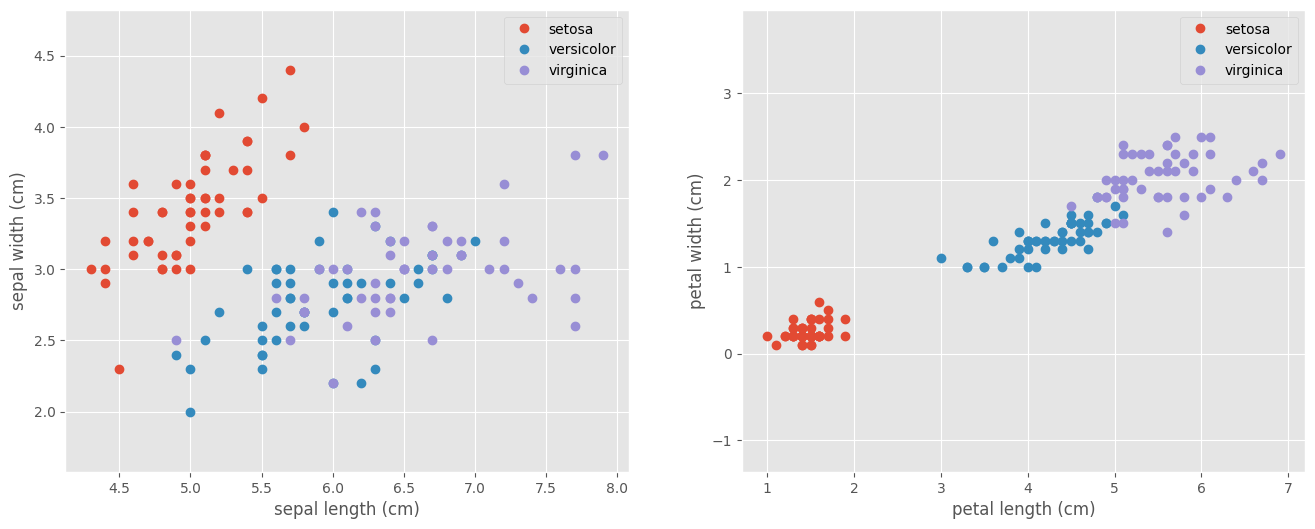

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend()

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend()

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [12]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

Now its time to run the training. In order to track progress more efficiently, we can use tqdm, which is a great and easy to use progress bar for our training epochs.

In [13]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 302.10it/s]


### Plot Accuracy and Loss from Training
Let’s have a look how our models perform. We can clearly see that adding more nodes makes the training perform better.

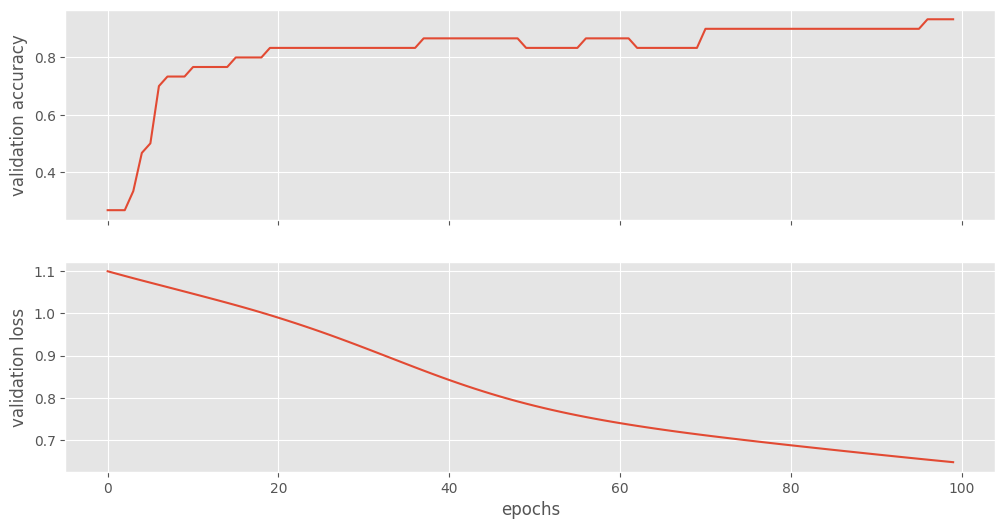

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

The ANN model achieved good accuracy on the test set, but we had to spend some effort on the dataset. In reality, we have to spend even more effort on fine-tuning the hyperparameters and prepare the dataset (standartization, normalization). Also, the output from the ANN model that we trained is one-hot vector which should be converted back into category values.

What about Decision Tree? We will try to implement decision tree along with data preparation steps and see how simpler is working with DT comparing to other machine learning algorithms, such as ANN.

In [17]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the DecisionTreeClassifier model with criterion gini index

iris = load_iris()
X, y = iris.data, iris.target

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

dt_clf = DecisionTreeClassifier()

# write one line to train the the decision tree on the train_x train_y train sets
dt_clf = dt_clf.fit(train_x, train_y)

score = dt_clf.score(test_x, test_y)
print(score)

1.0



As you can see, within a few lines we can train the Decision Tree classifier. Also, pay attention that, we did not spend any effort on data preparation (i.e. converting labels into one-hot encoding etc.)
We can also have more understanding the performance of our decision tree model by building a text report showing the rules of a decision tree.

In [20]:
r = export_text(dt_clf, feature_names=iris['feature_names'])
print(r)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.95
|   |   |--- petal width (cm) <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.65
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: 1
|   |--- petal length (cm) >  4.95
|   |   |--- petal width (cm) <= 1.75
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  1.75
|   |   |   |--- class: 2


Now let's see what kind of trees can we build with Sklearn.

If you have some problems with running the following code, make sure that you installed the graphviz (see instructions: https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft)

In [21]:
import graphviz
def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=iris.feature_names,
                       class_names=iris.target_names,
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph
graph = plot_tree(dt_clf)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Q/A

1.  What do leaves and branches represent in Decision trees?

2. When do we stop splitting the tree?

3. What is Entropy?

4. What is Information Gain?

Let's use a smaller Decison Tree and try to recreate some of the values on it.

Calculate the gini and entropy of the second branch (Petal width (cm) <= 1.75). 
you can hover over the branches to read their number.


![alt text](figs/impurity.png)

In [22]:
decision_tree = DecisionTreeClassifier(criterion = "entropy", max_depth=3)
decision_tree = decision_tree.fit(X, y)
plot_tree(decision_tree)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Let's implement the gini and entropy functions ourselves, and see how they are implemented like.

#### Recall the definitions.
The Gini Index is determined by deducting the sum of squared of probabilities of each class from one, mathematically, Gini Index can be expressed as:

![alt text](figs/gini.jpg)


Information Gain is applied to quantify which feature provides maximal information about the classification based on the notion of entropy, i.e. by quantifying the size of uncertainty, disorder or impurity, in general, with the intention of decreasing the amount of entropy initiating from the top (root node) to bottom(leaves nodes).

The information gain takes the product of probabilities of the class with a log having base 2 of that class probability, the formula for Entropy is given below:

![alt text](figs/entropy.jpg)

In [ ]:
import numpy as np
def gini(value):
    # write the body of this function that calculates the gini from an numpy array
    
    return # gini
def entropy(value):
    # write the body of this function that calculates the entropy of an numpy array
    return # entropy

value = np.array([50,50,0,10,0,10])
print("gini: {:.03}, entropy: {:.04} ".format(gini(value),entropy(value)))

Let's write a function that calculates the information gain that determines how good was the splitting process.

Recall the information gain formula:


![alt text](figs/Information-Gains-Entropy3.svg)
- a represents a specific attribute or class label
- Entropy(S) is the entropy of dataset, S
- |Sv|/ |S| represents the proportion of the values in Sv to the number of values in dataset, S
- Entropy(Sv) is the entropy of dataset, Sv

In [ ]:
def information_gain(parent, children):
    total = parent.sum()
    s = entropy(parent)
    for child in children:
        s -= child.sum()/total * entropy(child)
    return s
parent = np.array([50,50,50])
children = np.array([[50,0,0],[0,50,50]])
ig = information_gain(parent, children)
print("information gain: {:.03}".format(ig))

## Tree pruning

A simple tree prediction can lead to a model which overfits the data and produce bad results with the test data. Tree Pruning is the way to reduce overfitting by creating smaller trees.

Using the sklearn library, the DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores.


We will use simple data to check the effect of pruning on the Decision Tree. Let’s first get the data and split it accordingly.

In [ ]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides a method for DecisionTreeClassifier that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [ ]:
clf = DecisionTreeClassifier(random_state=0)

# write one line of code to get the a path variable which contains alphas and impurities
path = # your code here

ccp_alphas, impurities = path.ccp_alphas, path.impurities

Let's plot the relationship between alpha and impurities.

In [ ]:
fig, ax = plt.subplots()

ax.plot(ccp_alphas, impurities)
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")

Finding an optimal value of alpha.

In [ ]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)

    # write 2 lines of code to train the decision tree model on the train dataset and add the model into the clfs array

As we already know that there is a strong relation between, alpha and the depth of the tree. We can find the relation using this plot.

In [ ]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


The following graph demonstrates the relationship between alpha and accuracy.

In [ ]:
from sklearn.metrics import accuracy_score

# calculate the accuracy scores of the decision tree models in the clfs array, and add the scores into the acc_scores 
acc_scores = # your code here, you can write more than one line 

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

We can clearly see that somewhere around 0.013 alpha, we get a very good value of accuracy

## Comparison Between models
Now that you know multiple types of classifiers:
1. Linear
  * Logistic Regression
  * SVM-(with linear kernel)
2. Non-Linear
  * SVM-(with non linear kernel)
  * KNN
  * Decision Trees
  * Gaussian Naive Bayes
  
Let's take a look how their decision boundries look like.

In [ ]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Initializing Classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')

clf2 = DecisionTreeClassifier()
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10, 8))

labels = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
    


In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

References:
- https://scikit-learn.org/stable/modules/tree.html
- https://towardsdatascience.com/when-and-why-tree-based-models-often-outperform-neural-networks-ceba9ecd0fd8
- https://ranvir.xyz/blog/practical-approach-to-tree-pruning-using-sklearn/
- https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
- https://janakiev.com/blog/pytorch-iris/